### Importing Libraries 

In [1]:
import pandas as pd
from sklearn.preprocessing import  StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE

### Loading Data and Cleaning 

In [2]:
file_path = 'Loan.csv'
df = pd.read_csv(file_path)
missing_values = df.isnull().sum()
# print(missing_values) # no missing values in the dataset
# df.info()


X = df.drop(columns=['LoanApproved', 'RiskScore'])
y = df['LoanApproved']  

# Label encoding for categorical columns
le=LabelEncoder()
for cols in X.select_dtypes('object').columns:
    print(cols)
    X[cols]=le.fit_transform(X[cols])

# scaling of features
scaler=StandardScaler()
X=scaler.fit_transform(X)

X.shape, y.shape

ApplicationDate
EmploymentStatus
EducationLevel
MaritalStatus
HomeOwnershipStatus
LoanPurpose


((20000, 34), (20000,))

### Splitting the data into training and testing sets 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

'''We notice that the target variable is imbalanced. We will use SMOTE to balance the target variable.'''
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24474, 34), (4000, 34), (24474,), (4000,))

### Creating The Neural Network 

In [4]:
# Our Neural Network model
class LoanApprovalNN(nn.Module):
    def __init__(self):
        super(LoanApprovalNN, self).__init__()
        
        ''' Defining our layers (3 hidden layers) and output layer'''
        self.fc1 = nn.Linear(34, 32, bias=True)  # (34 inputs -> 32 neurons)  [[ Input to 1st hidden layer ]]
        self.fc2 = nn.Linear(32, 128, bias=True)  # (32 neurons -> 128 neurons) [[ 1st hidden layer to 2nd hidden layer ]]
        self.fc3 = nn.Linear(128, 32, bias=True)  # (128 neurons -> 32 neurons) [[ 2nd hidden layer to 3rd hidden layer ]]
        self.output = nn.Linear(32, 1, bias=True)  # (32 neurons -> 1 neuron) [[ 3rd hidden layer to output layer ]] -> # 1 neuron designating the probability of loan approval = 1 
        
    
        '''Dropout layer '''
        self.dropout = nn.Dropout(p  = 0.4) 

        ''' Activation functions '''
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        

    def forward(self, x):
        x = self.relu(self.fc1(x))  
        x = self.relu(self.fc2(x))  
        x = self.dropout(x) # Dropout is only applied during training. During evaluation ->  PyTorch will disable dropout.
        x = self.relu(self.fc3(x))  
        x = self.sigmoid(self.output(x))  
        return x


model = LoanApprovalNN()

summary(model, input_size=(34,)) # notice that if you want to see the summary of the model, using batches say of 10 samples, you can do summary(model, input_size=(10, 34)), but in the summary above, we are using a single sample of 34 features
# notice how to get the # of params in each layer you do the following: 
# in_features * number_nurons + bias(i.e.=number_of neurons) = # of params

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           1,120
              ReLU-2                   [-1, 32]               0
            Linear-3                  [-1, 128]           4,224
              ReLU-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 32]           4,128
              ReLU-7                   [-1, 32]               0
            Linear-8                    [-1, 1]              33
           Sigmoid-9                    [-1, 1]               0
Total params: 9,505
Trainable params: 9,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
-----------------------------------------------

### Defining Losses and optimizers

In [5]:
optimizer = optim.Adam(model.parameters(),lr=0.01)
loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss since we are working with binary classification

### Preparing the data into DataLoader for pytorch ( for batch training )

In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # making it [n, 1] shape

'''We will divide the data into batches and shuffle the data'''
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) # this is just like zipping, so that when we shuffle, we shuffle both X and y (without loosing the order)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 

### The Training 

In [7]:
num_epochs = 40  # Number of epochs
threshold = 0.5  # for the classification 
for epoch in range(num_epochs):
    model.train()  # we previously said that pytorch will disable dropout during evaluation, so we need to set the model to training mode not testing mode, to activate these things like dropout

    cum_loss = 0 # so once done it will contain the total cumulative loss for the epoch
    correct = 0
    total = len(train_loader.dataset)
    
    for inputs, targets in train_loader:
        batch_size = inputs.size(0)
        optimizer.zero_grad()  # Reset gradients to zero
        
        '''Forward pass'''
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        

        '''backward pass and update weights'''
        loss.backward()
        optimizer.step()
        
        '''Update our cumulative loss'''
        cum_loss += loss.item() * batch_size # loss.item() This loss is the average loss over all samples in that batch. But since our total is the # of all samples, we need to multiply by the batch size to get the total loss for this batch (i.e. average_loss * batch_size)
        

        '''Accuracy'''
        predicted = (outputs >= threshold).int()  
        correct += (predicted == targets).sum().item() # sum up all the correct predictions in this batch
        # note the .item() is used to get the value of the tensor as a python number (i.e. a scalar)
    
    
    '''Average Accuracy for this epoch'''
    epoch_loss = cum_loss / total
    epoch_accuracy = correct / total * 100
    
    print(f'Epoch {epoch+1} out of {num_epochs}, Loss: {epoch_loss:.5f}, Accuracy: {epoch_accuracy:.3f}%')


Epoch 1 out of 40, Loss: 0.14682, Accuracy: 94.227%
Epoch 2 out of 40, Loss: 0.11554, Accuracy: 95.612%
Epoch 3 out of 40, Loss: 0.10576, Accuracy: 95.787%
Epoch 4 out of 40, Loss: 0.10245, Accuracy: 96.024%
Epoch 5 out of 40, Loss: 0.10013, Accuracy: 96.167%
Epoch 6 out of 40, Loss: 0.09459, Accuracy: 96.302%
Epoch 7 out of 40, Loss: 0.09142, Accuracy: 96.380%
Epoch 8 out of 40, Loss: 0.09192, Accuracy: 96.359%
Epoch 9 out of 40, Loss: 0.08471, Accuracy: 96.519%
Epoch 10 out of 40, Loss: 0.08644, Accuracy: 96.580%
Epoch 11 out of 40, Loss: 0.08944, Accuracy: 96.441%
Epoch 12 out of 40, Loss: 0.08416, Accuracy: 96.743%
Epoch 13 out of 40, Loss: 0.08015, Accuracy: 96.793%
Epoch 14 out of 40, Loss: 0.07635, Accuracy: 96.915%
Epoch 15 out of 40, Loss: 0.07596, Accuracy: 96.833%
Epoch 16 out of 40, Loss: 0.07390, Accuracy: 97.013%
Epoch 17 out of 40, Loss: 0.07580, Accuracy: 97.058%
Epoch 18 out of 40, Loss: 0.07138, Accuracy: 97.123%
Epoch 19 out of 40, Loss: 0.07146, Accuracy: 97.197%
Ep

## Evaluation 

#### Preparding the testing data for batch testing (faster)

In [8]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # No need to shuffle for test data

#### The testing 

Test Loss: 0.2805
Test Accuracy: 94.58%


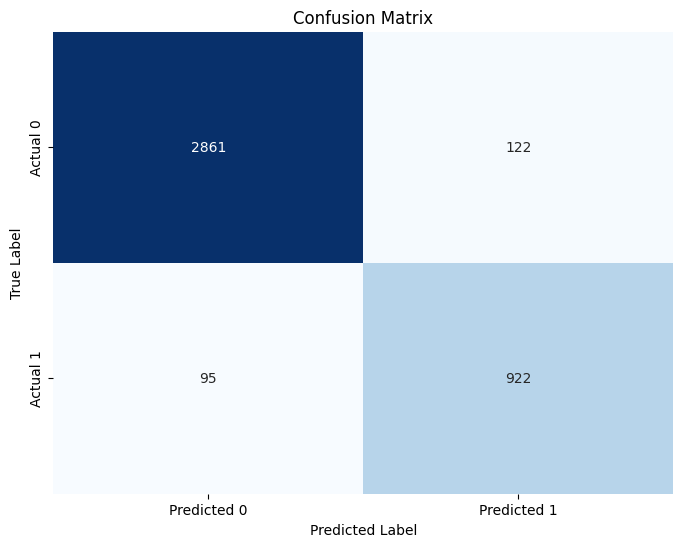

In [9]:
model.eval() # to let the model know that we are in evaluation mode, so that dropout is disabled for example 

test_loss = 0
correct = 0
total = 0
all_preds = []
all_true = []

# the "with" is to define a scope where the gradients are not computed, # instead we can generalize to use torch.set_grad_enabled(False)
with torch.no_grad(): # If we don’t use torch.no_grad() during evaluation, PyTorch will still compute and store gradients, even though we won’t use them. (NOT EFFICIENT)
    for inputs, targets in test_loader:  
        batch_size = inputs.size(0)

        # Forward pass
        outputs = model(inputs)
        
        
        loss = loss_function(outputs, targets)
        test_loss += loss.item() * batch_size 
        predicted = (outputs >= threshold).int()
        correct += (predicted == targets).sum().item()
        # predictions and true labels (for confusion matrix)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(targets.cpu().numpy())
        
        
        
total = len(test_loader.dataset)
average_loss = test_loss / total
accuracy = correct / total * 100
conf_matrix = confusion_matrix(all_true, all_preds)


print(f'Test Loss: {average_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()